In [13]:
import tensorflow as tf
import os  # for directory and file operations 
import random     # for generating random values for augmentation
import numpy as np     # for numerical operations and handling images arrays 
from sklearn.utils import shuffle # for shuffling the data 
import matplotlib.pyplot as plt   # for visualization
from PIL import Image, ImageEnhance  # for image processing and Enhancement
from tensorflow.keras.preprocessing.image import load_img ,img_to_array  # for loading images
from tensorflow.keras.models import Sequential      # for building the model
from tensorflow.keras.layers import Input,Flatten,Dropout,Dense   # for model layers
from tensorflow.keras.optimizers import Adam  # for optimizer


from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2,EfficientNetB0


# Pathset

In [17]:
#path set kiya h 
train_dir = r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Training"
test_dir = r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Testing"
IMAGE_SIZE =128

# Load and Shuffle data

In [18]:
# load and suffle the train data 

train_path = []
train_labels =[]
for label in os.listdir(train_dir):                   # 1. training ke andar jo folders hain unpe loop
    for image in os.listdir(os.path.join(train_dir,label)):      # 2. har folder ke andar ki images pe loop
        train_path.append(os.path.join(train_dir,label,image))    # 3. image ka full path list me daalna 
        train_labels.append(label)                                 # 4. us image ka label (folder ka naam) list me daalna
        

train_path,train_labels = shuffle(train_path,train_labels)

#load and shuffle the test data
test_path = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir,label)):
        test_path.append(os.path.join(test_dir,label,image))
        test_labels.append(label)

test_path,test_labels = shuffle(test_path,test_labels)        


# Data Visualization

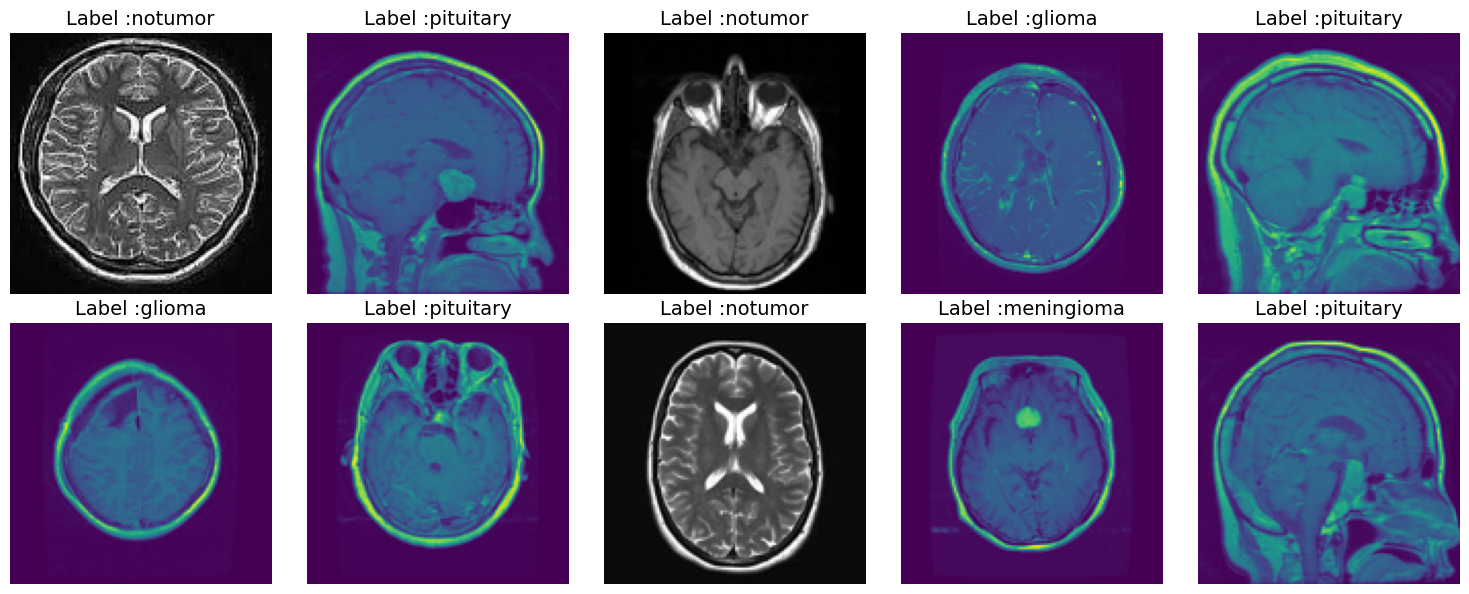

In [19]:
# select random indies for 10 images 
random_indices = random.sample(range(len(train_path)),10)

# create a figure to display images in 2 rows 
fig,axes = plt.subplots(2,5,figsize=(15,6))
axes = axes.ravel()     #axes ek 2D array of subplots hota hai, aur .ravel() use karke hum use 1D array bana lete hain (easy looping ke liye).

# Loop through the random indices and display images
for i ,idx in enumerate(random_indices):     #
    img_path = train_path[idx]    # ek random image ka path nikalna
    img = Image.open(img_path)    # PIL library se image ko open karna
    img = img.resize((128,128))   # image ko 128×128 px resize karna (uniform size ke liye)

    # Display images
    axes[i].imshow(img)     #i-th subplot me image show karna
    axes[i].axis("off")     #axis (x,y scale lines) ko hatana
    axes[i].set_title(f"Label :{train_labels[idx]}",fontsize = 14)
    
plt.tight_layout()
plt.show()

# Image Preprocessing

In [27]:
# Image Augmentation Function 
def augemnt_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))  # Random Brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))   # Random contrast
    image = np.array(image)/255.0   # Normalize pixel values to [0,1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path,target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image =augemnt_image(image)
        images.append(image)
    return np.array(images)    

    
# Encoder labels (Convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)   # Ensure unidue labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths,labels,batch_size = 12,epochs=1):
    for _ in range(epochs):
        for i in range(0,len(paths),batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_images(batch_paths)   # open and augment images
            batch_labels = labels[i:i+batch_size]
            batch_labels = encode_label(batch_labels)   # Encode labels
            
            yield batch_images,batch_labels    # Yield the batch 
        

#  Model

In [21]:
# Build Model
def build_model(base_model_class):
    base_model = base_model_class(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

    # Freeze base model layers to retain pre-trained features
    for layer in base_model.layers: 
        layer.trainable = False

    # You may choose to unfreeze some of the last layers (optional)
    if len(base_model.layers) >= 4:
        base_model.layers[-2].trainable = True
        base_model.layers[-3].trainable = True
        base_model.layers[-4].trainable = True

    # Define top layers for classification
    model = Sequential()
    model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax

    # Compile model with Adam optimizer and sparse categorical loss
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

# Hyperparameters
batch_size = 20
steps_per_epoch = len(train_path) // batch_size
epochs = 10

In [24]:
# Train multiple models
# =======================
IMAGE_SIZE =128

model_dict = {'VGG16': VGG16, 'ResNet50': ResNet50, 'MobileNetV2': MobileNetV2, 'EfficientNetB0': EfficientNetB0}
histories = {}

for model_name, base_model_fn in model_dict.items():
    print(f"Training {model_name} model...")

    model = build_model(base_model_fn)

    # Train using data generator
    history = model.fit(
        datagen(train_path, train_labels, batch_size=batch_size, epochs=epochs),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch
    )
    histories[model_name] = history.history

    # Save the trained model
    model.save(f"{model_name}_model.keras")
    print(f"{model_name} model saved.")

Training VGG16 model...
Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - loss: 0.4391 - sparse_categorical_accuracy: 0.8316
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9236
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - loss: 0.1535 - sparse_categorical_accuracy: 0.9433
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - loss: 0.1081 - sparse_categorical_accuracy: 0.9617
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - loss: 0.0717 - sparse_categorical_accuracy: 0.9735
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9780
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - loss: 0.0697 - sparse_categorical_accuracy: 0.9768
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - loss: 0.0403 - sparse_categorical_accuracy: 0.9866
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9931
Epoch 10/10
285/285 ━━

ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [25]:
print(histories)

{'VGG16': {'loss': [0.4391137659549713, 0.2144593894481659, 0.1535062938928604, 0.10805630683898926, 0.0716669112443924, 0.06086226925253868, 0.06967367976903915, 0.04029351472854614, 0.02067083865404129, 0.04470592737197876], 'sparse_categorical_accuracy': [0.8315789699554443, 0.9235769510269165, 0.9432536959648132, 0.9617006182670593, 0.9734715223312378, 0.9780393242835999, 0.976809561252594, 0.98664790391922, 0.9931482672691345, 0.986120879650116]}, 'ResNet50': {'loss': [0.7795093059539795, 0.5795390009880066, 0.5286776423454285, 0.48757389187812805, 0.4551592469215393, 0.44330236315727234, 0.428346186876297, 0.39340266585350037, 0.36930549144744873, 0.3463800549507141], 'sparse_categorical_accuracy': [0.6770175695419312, 0.7619466185569763, 0.7891777753829956, 0.7930428385734558, 0.8162333369255066, 0.8222066164016724, 0.8230850100517273, 0.8401265144348145, 0.8492621183395386, 0.8555867671966553]}, 'MobileNetV2': {'loss': [0.4442274868488312, 0.15489546954631805, 0.077760554850101

# Confusion Matrix , Classwise Accuracy, Overall Accuray of models


Loading and evaluating model: VGG16
41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step

Classification Report for VGG16:
              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.90      0.97      0.94       306
     notumor       0.99      1.00      1.00       405
   pituitary       1.00      0.96      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.97      1311
weighted avg       0.97      0.97      0.97      1311



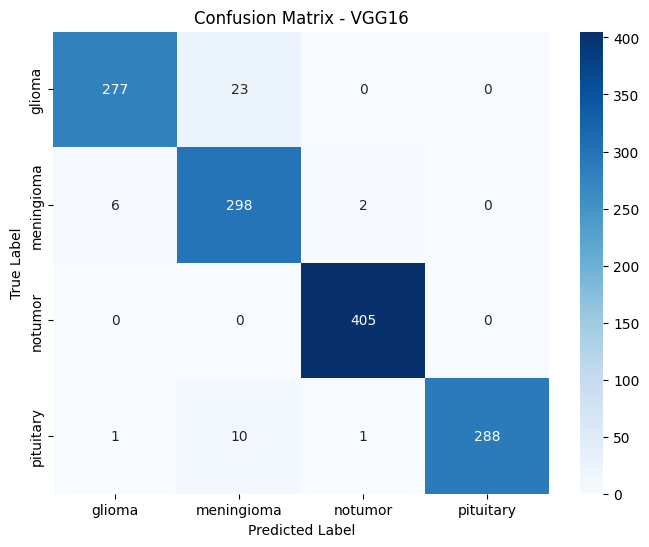

Overall accuracy for VGG16: 96.72%
Classwise Accuracy:
glioma: 92.33%
meningioma: 97.39%
notumor: 100.00%
pituitary: 96.00%
--------------------------------------------------

Loading and evaluating model: ResNet50
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 859ms/step

Classification Report for ResNet50:
              precision    recall  f1-score   support

      glioma       0.55      0.93      0.69       300
  meningioma       0.77      0.43      0.55       306
     notumor       0.95      0.78      0.86       405
   pituitary       0.87      0.87      0.87       300

    accuracy                           0.75      1311
   macro avg       0.78      0.75      0.74      1311
weighted avg       0.80      0.75      0.75      1311



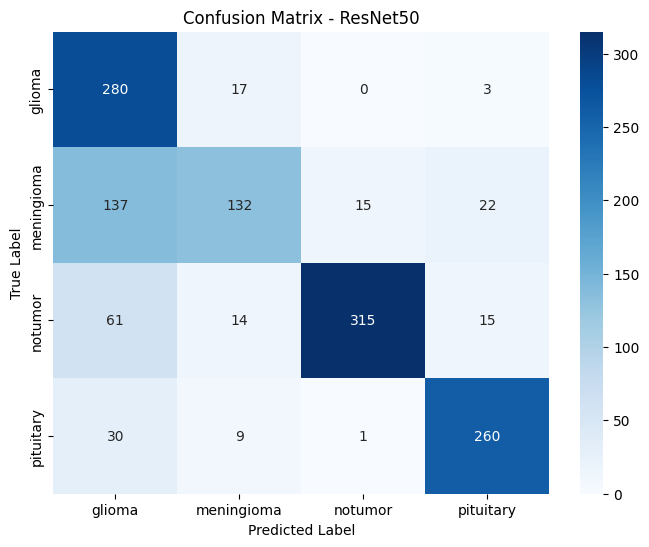

Overall accuracy for ResNet50: 75.29%
Classwise Accuracy:
glioma: 93.33%
meningioma: 43.14%
notumor: 77.78%
pituitary: 86.67%
--------------------------------------------------

Loading and evaluating model: MobileNetV2
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step

Classification Report for MobileNetV2:
              precision    recall  f1-score   support

      glioma       0.95      0.94      0.94       300
  meningioma       0.93      0.94      0.94       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.98      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



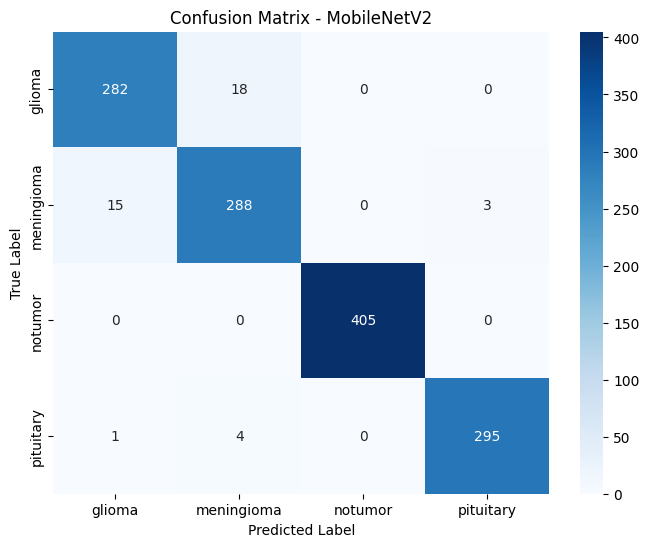

Overall accuracy for MobileNetV2: 96.87%
Classwise Accuracy:
glioma: 94.00%
meningioma: 94.12%
notumor: 100.00%
pituitary: 98.33%
--------------------------------------------------


In [29]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test data load karen (same as before)
test_images = open_images(test_path)     # aapka open_images function
test_labels_encoded = encode_label(test_labels)  # aapka encode_labels function
class_labels = sorted(os.listdir(train_dir))

model_files = {
    'VGG16': 'VGG16_model.keras',
    'ResNet50': 'ResNet50_model.keras',
    'MobileNetV2': 'MobileNetV2_model.keras'
}
for model_name, model_path in model_files.items():
    print(f"\nLoading and evaluating model: {model_name}")
    model = load_model(model_path)

    predictions = model.predict(test_images)
    y_pred = np.argmax(predictions, axis=1)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(test_labels_encoded, y_pred, target_names=class_labels))

    conf_mat = confusion_matrix(test_labels_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    report_dict = classification_report(test_labels_encoded, y_pred, target_names=class_labels, output_dict=True)
    overall_accuracy = report_dict['accuracy'] * 100
    print(f"Overall accuracy for {model_name}: {overall_accuracy:.2f}%")
    print("Classwise Accuracy:")
    for cls in class_labels:
        recall = report_dict[cls]['recall']
        print(f"{cls}: {recall * 100:.2f}%")
    print("-" * 50)


# Graph plot for Training history

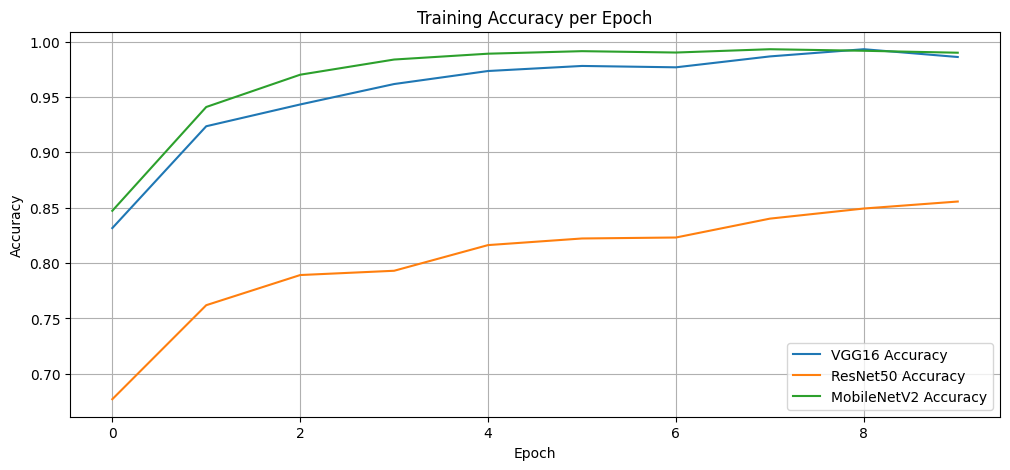

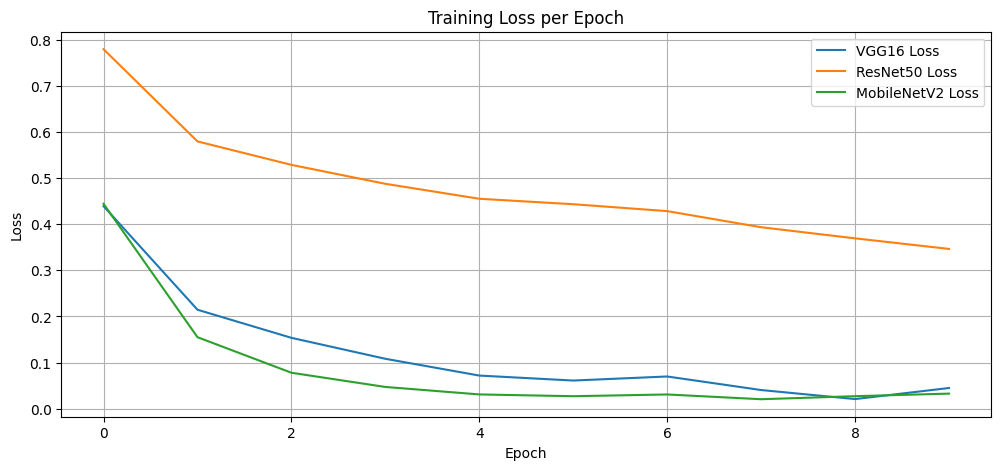

In [30]:
# Plot training history summary
# ===============================
plt.figure(figsize=(12, 5))
for model_name, hist in histories.items():
    plt.plot(hist['sparse_categorical_accuracy'], label=f'{model_name} Accuracy')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for model_name, hist in histories.items():
    plt.plot(hist['loss'], label=f'{model_name} Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve

Found 1311 files belonging to 4 classes.
📊 Generating ROC curve for VGG16...


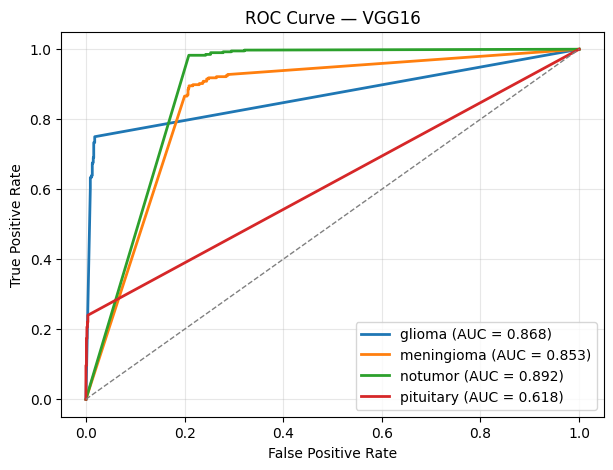

 Done plotting for VGG16

📊 Generating ROC curve for ResNet50...


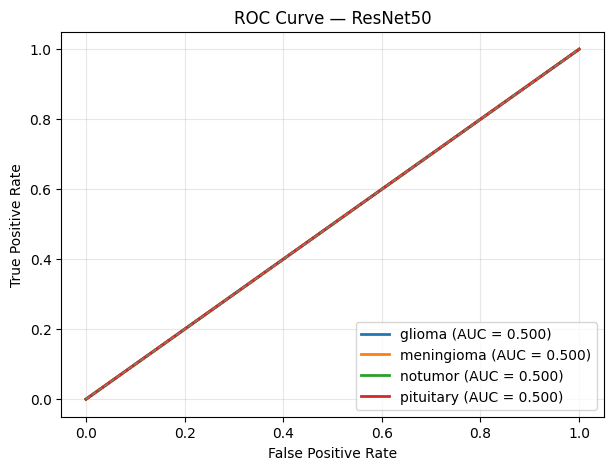

 Done plotting for ResNet50

📊 Generating ROC curve for MobileNetV2...


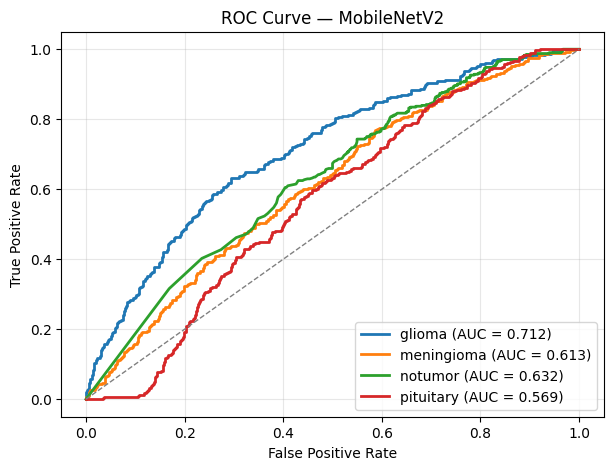

 Done plotting for MobileNetV2

 Model file not found: EfficientNetB0_model.keras, skipping...



In [70]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory


# 1️ Setup Paths and Parameters
train_dir = r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Training"
test_dir = r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Testing"

class_labels = sorted(os.listdir(train_dir))
num_classes = len(class_labels)

# Model names and saved file paths
model_names = ["VGG16", "ResNet50", "MobileNetV2", ]
model_paths = [f"{name}_model.keras" for name in model_names]


# 2️ Load Test Dataset

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),   #  Change to (224, 224) if models trained on 224x224
    batch_size=32,
    shuffle=False
)

# Extract all test images and labels
test_images = np.concatenate([x for x, y in test_dataset], axis=0)
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
test_labels_encoded = np.argmax(test_labels, axis=1) if len(test_labels.shape) > 1 else test_labels

# Binarize labels for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(num_classes))


# 3️ Generate ROC Curves per Model

for model_name, model_path in zip(model_names, model_paths):

    if not os.path.exists(model_path):
        print(f" Model file not found: {model_path}, skipping...\n")
        continue

    print(f"📊 Generating ROC curve for {model_name}...")

    # Load model
    model = load_model(model_path)

    # Predict probabilities for test set
    predictions = model.predict(test_images, verbose=0)

    # Initialize ROC data
    fpr, tpr, roc_auc = {}, {}, {}

    # Compute ROC and AUC per class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

   
    # 4️ Plot ROC for this model
    
    plt.figure(figsize=(7, 5))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.title(f"ROC Curve — {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    print(f" Done plotting for {model_name}\n")


# MRI Tumor Detection System

In [52]:
# from keras.preprocessing.image import load_img, img_to_array

# #class_labels = ['glioma','meningioma','notumor','pituitary']
# def detect_and_display(image_path,model):
#     try:
#         # load image
#         img= load_img(image_path,target_size =(128,128))
#         img_array = img_to_array(img)
#         img_array = np.expand_dims(img_array,axis = 0)

#         # predictions
#         predictions = model.predict(img_array)   # 0=0.90, 1= 0.59, 2= 0.99,3 = 87
#         predicted_class_index = np.argmax(predictions)
#         confidence_score = np.max(predictions, axis=1)[0]


#         # determine the class
#         if class_labels[predicted_class_index]=='notumor':
#             result =  " No Tumor"
#         else:
#             result = f" Tumor : {class_labels[predicted_class_index]}"

#         # Display 
#         plt.imshow(load_img(image_path))
#         plt.axis('off')
#         plt.title(f"{result} Confidence: {confidence_score*100:.2f}%")
#         plt.show()

#     except Exception as e :
#         print("Error processing the image:",str(e))

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


#Load the Trained Model

model_path = "MobileNetV2_model.keras"   # Make sure this file exists in your directory
MobileNetV2_model = load_model(model_path)
print("✅ MobileNetV2 model loaded successfully!")


# 2️ Define Class Labels

# Must be in the same order as training folders
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']


# 3️ Define Prediction Function

def detect_and_display(image_path, model):
    try:
        # load image
        img = load_img(image_path, target_size=(128, 128))  # resized to match training input
        img_array = img_to_array(img) / 255.0               # normalization
        img_array = np.expand_dims(img_array, axis=0)

        # predictions
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions)
        confidence_score = np.max(predictions)

        # determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor Detected"
        else:
            result = f"Tumor Type: {class_labels[predicted_class_index]}"

        # Display
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{result}\nConfidence: {confidence_score*100:.2f}%")
        plt.show()

    except Exception as e:
        print(" Error processing the image:", str(e))



✅ MobileNetV2 model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


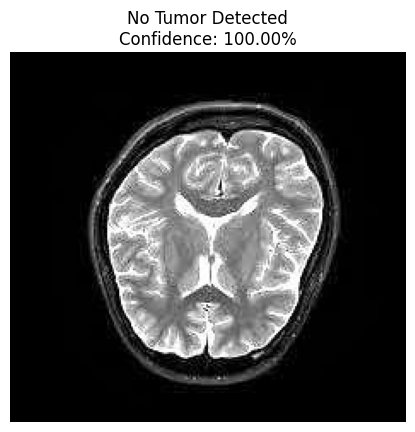

In [60]:

# 4️ Run the Detection

image_path = r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Testing\notumor\Te-no_0288.jpg"
detect_and_display(image_path, MobileNetV2_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


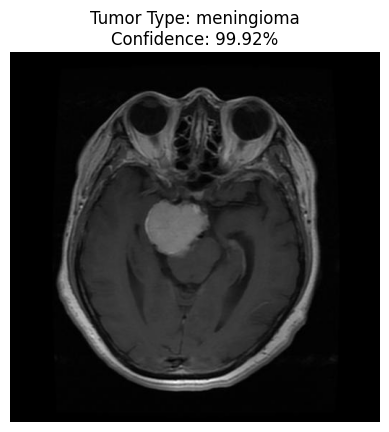

In [61]:
image_path = r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Testing\meningioma\Te-me_0132.jpg"
detect_and_display(image_path ,MobileNetV2_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


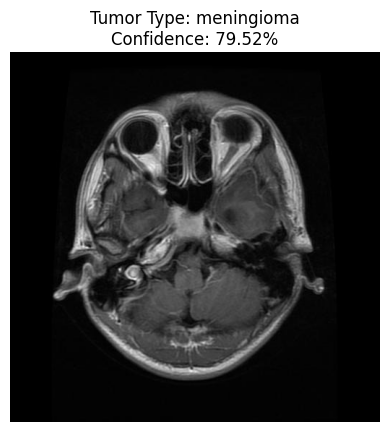

In [63]:
image_path=r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Testing\glioma\Te-glTr_0003.jpg"
detect_and_display(image_path,MobileNetV2_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


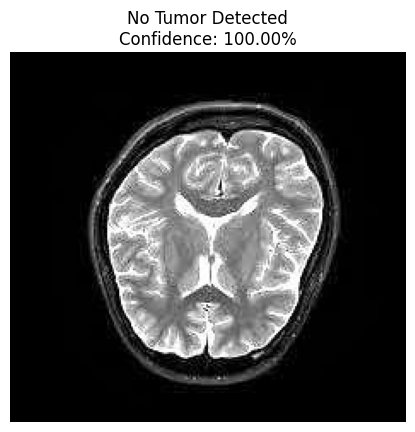

In [64]:
# Example usage 
image_path ="C:/Users/Shivani Saini/Downloads/Brain tumar MRI/Testing/notumor/Te-no_0288.jpg"
detect_and_display(image_path,  MobileNetV2_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


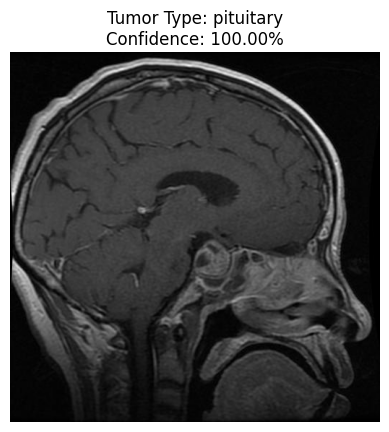

In [71]:
image_path = r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Testing\pituitary\Te-pi_0096.jpg"
detect_and_display(image_path,MobileNetV2_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


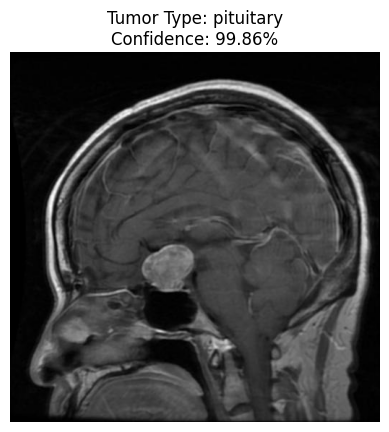

In [72]:
image_path = r"C:\Users\Shivani Saini\Downloads\Brain tumar MRI\Testing\pituitary\Te-piTr_0008.jpg"
detect_and_display(image_path,MobileNetV2_model)